# 06. 사이킷런으로 수행하는 타이타닉 생존자 예측

1) 데이터 불러오기, 데이터 전처리

① Null 값 처리

② 데이터 속성값 정리

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

titanic_df = pd.read_csv("./titanic_train.csv")
print("\n ### 학습 데이터 정보 ### \n")
print(titanic_df.info())


 ### 학습 데이터 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [2]:
titanic_df['Age'].fillna(titanic_df['Age'].mean(), inplace=True)
titanic_df['Cabin'].fillna('N', inplace=True)
titanic_df['Embarked'].fillna('N', inplace=True)
print('데이터 세트 Null 값 개수 ', titanic_df.isnull().sum().sum())

데이터 세트 Null 값 개수  0


In [3]:
print(' Sex 값 분포 :\n', titanic_df['Sex'].value_counts())
print('\n Cabin 값 분포 :\n', titanic_df['Cabin'].value_counts())
print('\n Embarked 값 분포 :\n', titanic_df['Embarked'].value_counts)
titanic_df['Cabin'] = titanic_df['Cabin'].str[:1]
print(titanic_df['Cabin'].head(3))

 Sex 값 분포 :
 male      577
female    314
Name: Sex, dtype: int64

 Cabin 값 분포 :
 N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64

 Embarked 값 분포 :
 <bound method IndexOpsMixin.value_counts of 0      S
1      C
2      S
3      S
4      S
      ..
886    S
887    S
888    S
889    C
890    Q
Name: Embarked, Length: 891, dtype: object>
0    N
1    C
2    N
Name: Cabin, dtype: object


2) 데이터 탐색

① 성별, 부(객실 등급), 나이에 따른 생존확률 비교 : 세 변수 모두 생존과 유의미한 상관관계를 가짐

In [4]:
titanic_df.groupby(['Sex', 'Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

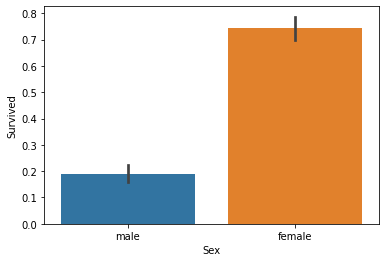

In [5]:
sns.barplot(x='Sex', y='Survived', data=titanic_df)

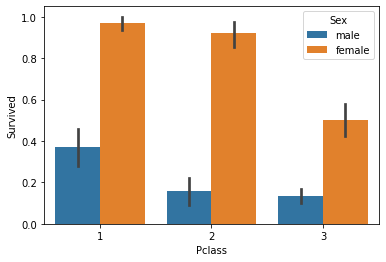

In [6]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=titanic_df)

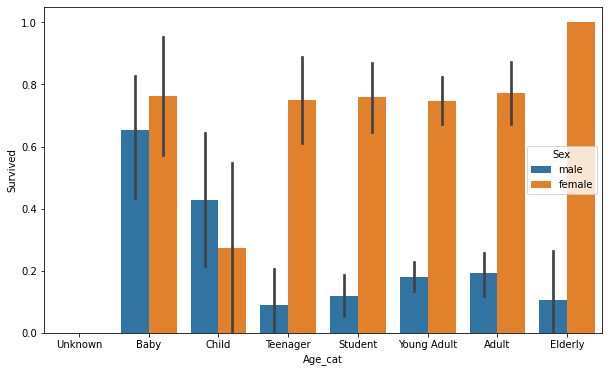

In [7]:
def get_category(age):
  cat = ''
  if age <= -1 : cat = "Unknown"
  elif age <= 5 : cat = "Baby"
  elif age <= 12 : cat = 'Child'
  elif age <= 18 : cat = "Teenager"
  elif age <= 25 : cat = "Student"
  elif age <= 35 : cat = "Young Adult"
  elif age <= 60 : cat = "Adult"
  else : cat = "Elderly"

  return cat

plt.figure(figsize=(10,6))

group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=titanic_df, order=group_names)
titanic_df.drop('Age_cat', axis=1, inplace=True)

3) 문자열 카테고리 피처 → 숫자형 카테고리 피처 (by 레이블 인코딩)

In [8]:
from sklearn import preprocessing

def encode_features(dataDF):
  features = ['Cabin', 'Sex', 'Embarked']
  for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(dataDF[feature])
    dataDF[feature] = le.transform(dataDF[feature])
  
  return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


4) 1),3)을 한꺼번에 하는 새로운 함수 생성



In [13]:
def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace=True)
  df['Cabin'].fillna('N', inplace=True)
  df['Embarked'].fillna('N', inplace=True)
  df['Fare'].fillna('N', inplace=True)
  return df

def drop_features(df):
  df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
  return df

def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin', 'Sex', 'Embarked']
  for feature in features:
    le = preprocessing.LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])
  return df

def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

5) 피처 데이터 세트, 레이블 데이터 세트 추출 후 train data / test data 분리

In [14]:
titanic_df = pd.read_csv("./titanic_train.csv")
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

X_titanic_df = transform_features(X_titanic_df)

6) 머신러닝 알고리즘 이용하여 타이타닉 생존자 예측

① 결정트리 : DecisionTreeClassifier

② 랜덤 포레스트 :  RandomForestClassifier

③ 로지스틱 회귀 : LogisticRegression

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size = 0.2,
                                                    random_state=11)

7) accuracy_score 이용, 정확도로 예측성능 평가 : 로지스틱 회귀가 다른 알고리즘에 비해 정확도 높음

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print("DecisionTreeClassifier 정확도 : {0:.4f}".format(accuracy_score(y_test, dt_pred)))

rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print("RandomForestClassifier 정확도 : {0:.4f}".format(accuracy_score(y_test, rf_pred)))

lr_clf.fit(X_train, y_train)
lr_pred =lr_clf.predict(X_test)
print("DecisionTreeClassifier 정확도 : {0:.4f}".format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도 : 0.7877
RandomForestClassifier 정확도 : 0.8547
DecisionTreeClassifier 정확도 : 0.8492


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


8) 교차검증 : KFold, cross_val_score(), GridSearchCV 사용

In [21]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds=5):
  kfold = KFold(n_splits=folds)
  scores=[]

  for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
    X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
    y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]

    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    scores.append(accuracy)
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))
  
  mean_score = np.mean(scores)
  print("평균 정확도: {0:.4f}".format(mean_score))

exec_kfold(dt_clf, folds=5)

교차 검증 0 정확도: 0.7542
교차 검증 1 정확도: 0.7809
교차 검증 2 정확도: 0.7865
교차 검증 3 정확도: 0.7697
교차 검증 4 정확도: 0.8202
평균 정확도: 0.7823


In [23]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)

for iter_count, accuracy in enumerate(scores):
  print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))


print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검증 0 정확도: 0.7430
교차 검증 1 정확도: 0.7753
교차 검증 2 정확도: 0.7921
교차 검증 3 정확도: 0.7865
교차 검증 4 정확도: 0.8427
평균 정확도: 0.7879


In [25]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2,3,5,10],
              'min_samples_split':[2,3,5], 
              'min_samples_leaf':[1,5,8]}

grid_dclf = GridSearchCV(dt_clf, param_grid = parameters, scoring = 'accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print("GridSearchCV 최적 하이퍼 파라미터 :", grid_dclf.best_params_)
print("GridSearchCV 최고 정확도: {0:.4f}".format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print("테스트 세트에서의 DecisionTreeClassifier 정확도 : {0:.4f}".format(accuracy))

GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992
테스트 세트에서의 DecisionTreeClassifier 정확도 : 0.8715
